In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=5e9ddad0d5232db17057c2da500c2c1194fd6580730daceff637cfe411842854
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [4]:
from xgboost.spark import SparkXGBClassifier

In [5]:
# Import PySpark related modules
import pyspark
import pyspark.sql.functions as f
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [6]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression,\
                    RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col

In [7]:
spark = SparkSession.builder.appName('Loan Default').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/31 13:24:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
from itertools import chain
from pyspark.sql.functions import count, mean, when, lit, create_map, regexp_extract

In [9]:
df = spark.read.csv('../input/loandefault/train.csv', header=True, inferSchema=True)

In [10]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Loan Amount: integer (nullable = true)
 |-- Funded Amount: integer (nullable = true)
 |-- Funded Amount Investor: double (nullable = true)
 |-- Term: integer (nullable = true)
 |-- Batch Enrolled: string (nullable = true)
 |-- Interest Rate: double (nullable = true)
 |-- Grade: string (nullable = true)
 |-- Sub Grade: string (nullable = true)
 |-- Employment Duration: string (nullable = true)
 |-- Home Ownership: double (nullable = true)
 |-- Verification Status: string (nullable = true)
 |-- Payment Plan: string (nullable = true)
 |-- Loan Title: string (nullable = true)
 |-- Debit to Income: double (nullable = true)
 |-- Delinquency - two years: integer (nullable = true)
 |-- Inquires - six months: integer (nullable = true)
 |-- Open Account: integer (nullable = true)
 |-- Public Record: integer (nullable = true)
 |-- Revolving Balance: integer (nullable = true)
 |-- Revolving Utilities: double (nullable = true)
 |-- Total Accounts: intege

In [11]:
df.show(3)

23/07/31 13:24:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-----------+-------------+----------------------+----+--------------+-------------+-----+---------+-------------------+--------------+-------------------+------------+------------------+---------------+-----------------------+---------------------+------------+-------------+-----------------+-------------------+--------------+-------------------+-----------------------+-----------------------+------------------+-----------------------+----------------------------+----------------+-------------+-------------------+-----------------------+---------------------+----------------------------+-----------+
|      ID|Loan Amount|Funded Amount|Funded Amount Investor|Term|Batch Enrolled|Interest Rate|Grade|Sub Grade|Employment Duration|Home Ownership|Verification Status|Payment Plan|        Loan Title|Debit to Income|Delinquency - two years|Inquires - six months|Open Account|Public Record|Revolving Balance|Revolving Utilities|Total Accounts|Initial List Status|Total Received Interest|T

In [12]:
df.limit(3).toPandas()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,...,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,...,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,...,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,...,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0


In [13]:
df.select('Loan Amount', 'Funded Amount Investor', 'Grade', 'Loan Status', 'Interest Rate').show(3)

+-----------+----------------------+-----+-----------+-------------+
|Loan Amount|Funded Amount Investor|Grade|Loan Status|Interest Rate|
+-----------+----------------------+-----+-----------+-------------+
|      10000|           12329.36286|    B|          0|  11.13500686|
|       3609|           12191.99692|    C|          0|  12.23756263|
|      28276|           21603.22455|    F|          0|  12.54588365|
+-----------+----------------------+-----+-----------+-------------+
only showing top 3 rows



In [14]:
df.select('Loan Amount', 'Funded Amount Investor', 'Interest Rate').summary().show(3)

+-------+------------------+----------------------+------------------+
|summary|       Loan Amount|Funded Amount Investor|     Interest Rate|
+-------+------------------+----------------------+------------------+
|  count|             67463|                 67463|             67463|
|   mean|16848.902776336658|    14621.799322594257|11.846257897060335|
| stddev| 8367.865726383838|     6785.345169773664| 3.718628715476197|
+-------+------------------+----------------------+------------------+
only showing top 3 rows



In [15]:
print('Number of rows: \t', df.count())
print('Number of columns: \t', len(df.columns))

Number of rows: 	 67463
Number of columns: 	 35


In [16]:
df.groupBy('Loan Status').count().show()

+-----------+-----+
|Loan Status|count|
+-----------+-----+
|          1| 6241|
|          0|61222|
+-----------+-----+



In [17]:
description = df.describe().collect()
description

[Row(summary='count', ID='67463', Loan Amount='67463', Funded Amount='67463', Funded Amount Investor='67463', Term='67463', Batch Enrolled='67463', Interest Rate='67463', Grade='67463', Sub Grade='67463', Employment Duration='67463', Home Ownership='67463', Verification Status='67463', Payment Plan='67463', Loan Title='67463', Debit to Income='67463', Delinquency - two years='67463', Inquires - six months='67463', Open Account='67463', Public Record='67463', Revolving Balance='67463', Revolving Utilities='67463', Total Accounts='67463', Initial List Status='67463', Total Received Interest='67463', Total Received Late Fee='67463', Recoveries='67463', Collection Recovery Fee='67463', Collection 12 months Medical='67463', Application Type='67463', Last week Pay='67463', Accounts Delinquent='67463', Total Collection Amount='67463', Total Current Balance='67463', Total Revolving Credit Limit='67463', Loan Status='67463'),
 Row(summary='mean', ID='2.562760774649808E7', Loan Amount='16848.902

## Loan Grade

In [18]:
grade_df = df.select("Grade", "ID") \
    .distinct() \
    .groupBy("Grade") \
    .count() \
    .orderBy("count", ascending=False)

# Top 5 grades
highest_grade_df = grade_df.limit(5).toPandas()
highest_grade_df.rename(columns = {'count':'Grade'}, inplace = True)
# Caculate the total users, we will this result to compute percentage later
total_grade_users = grade_df.groupBy().sum().collect()[0][0]

In [19]:
grade_df.collect()[:5]

[Row(Grade='C', count=19085),
 Row(Grade='B', count=18742),
 Row(Grade='A', count=12055),
 Row(Grade='D', count=8259),
 Row(Grade='E', count=6446)]

There are total: 7 grade of loans and here is the chart for grades based on loan status:


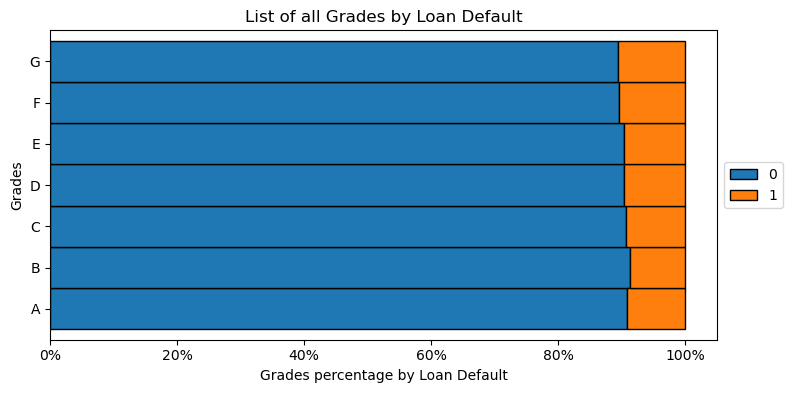

In [20]:
total_grades = grade_df.count()
print(f'There are total: {total_grades} grade of loans and here is the chart for grades based on loan status:')
# Add the infor of grades based on loan default
df20 = df.groupBy('Grade', 'Loan Status').count().toPandas()
# Visualize
fig = plt.figure(figsize=(8, 4))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = df20.groupby(['Grade', 'Loan Status']).agg(np.mean).groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', stacked=True, width=1  ## APPLY UNSTACK TO RESHAPE DATA
                , edgecolor='black', ax=ax, title='List of all Grades by Loan Default')
ylabel = plt.ylabel('Grades');
xlabel = plt.xlabel('Grades percentage by Loan Default');
legend = plt.legend(
    sorted(df20['Loan Status'].unique()), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 9});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

In [21]:
#Checking for missing values
for column in df.columns:
    print(column.ljust(20), df.filter(df[column].isNull()).count())

ID                   0
Loan Amount          0
Funded Amount        0
Funded Amount Investor 0
Term                 0
Batch Enrolled       0
Interest Rate        0
Grade                0
Sub Grade            0
Employment Duration  0
Home Ownership       0
Verification Status  0
Payment Plan         0
Loan Title           0
Debit to Income      0
Delinquency - two years 0
Inquires - six months 0
Open Account         0
Public Record        0
Revolving Balance    0
Revolving Utilities  0
Total Accounts       0
Initial List Status  0
Total Received Interest 0
Total Received Late Fee 0
Recoveries           0
Collection Recovery Fee 0
Collection 12 months Medical 0
Application Type     0
Last week Pay        0
Accounts Delinquent  0
Total Collection Amount 0
Total Current Balance 0
Total Revolving Credit Limit 0
Loan Status          0


In [22]:
string_col = [i[0] for i in df.dtypes if i[1] == "string"]
string_col

['Batch Enrolled',
 'Grade',
 'Sub Grade',
 'Employment Duration',
 'Verification Status',
 'Payment Plan',
 'Loan Title',
 'Initial List Status',
 'Application Type']

In [23]:
stringIndex = StringIndexer(inputCols=string_col, 
                       outputCols=['BatchEnrolled',
                                     'GradeCol',
                                     'SubGrade',
                                     'EmploymentDuration',
                                     'VerificationStatus',
                                     'PaymentPlan',
                                     'LoanTitle',
                                     'InitialListStatus',
                                     'ApplicationType'])

stringIndex_model = stringIndex.fit(df)

df_ = stringIndex_model.transform(df).drop('Batch Enrolled',
 'Grade',
 'Sub Grade',
 'Employment Duration',
 'Verification Status',
 'Payment Plan',
 'Loan Title',
 'Initial List Status',
 'Application Type')
df_.toPandas().head(3)


,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,...,Loan Status,BatchEnrolled,GradeCol,SubGrade,EmploymentDuration,VerificationStatus,PaymentPlan,LoanTitle,InitialListStatus,ApplicationType
0,65087372,10000,32236,12329.36286,59,11.135007,176346.62670,16.284758,1,0,...,0,25.0,1.0,7.0,0.0,2.0,0.0,2.0,0.0,0.0
1,1450153,3609,11940,12191.99692,59,12.237563,39833.92100,15.412409,0,0,...,0,1.0,0.0,17.0,1.0,0.0,0.0,1.0,1.0,0.0
2,1969101,28276,9311,21603.22455,59,12.545884,91506.69105,28.137619,0,0,...,0,14.0,5.0,13.0,0.0,0.0,0.0,2.0,0.0,0.0


In [24]:
# List of columns to convert to float
int_or_string_cols = [
    col_name for col_name, col_type in df_.dtypes
    if col_type in ['int', 'bigint', 'string']
]

# Convert integer and string columns to float
for col_name in int_or_string_cols:
    df_ = df_.withColumn(col_name, col(col_name).cast("double"))

In [25]:
df_.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  float64
 1   Loan Amount                   67463 non-null  float64
 2   Funded Amount                 67463 non-null  float64
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  float64
 5   Interest Rate                 67463 non-null  float64
 6   Home Ownership                67463 non-null  float64
 7   Debit to Income               67463 non-null  float64
 8   Delinquency - two years       67463 non-null  float64
 9   Inquires - six months         67463 non-null  float64
 10  Open Account                  67463 non-null  float64
 11  Public Record                 67463 non-null  float64
 12  Revolving Balance             67463 non-null  float64
 13  R

In [26]:
# assume the label column is named "class"
label = "Loan Status"

# get a list with feature column names
feature_names = [i for i in df_.columns[1:] if i != label]
feature_names

['Loan Amount',
 'Funded Amount',
 'Funded Amount Investor',
 'Term',
 'Interest Rate',
 'Home Ownership',
 'Debit to Income',
 'Delinquency - two years',
 'Inquires - six months',
 'Open Account',
 'Public Record',
 'Revolving Balance',
 'Revolving Utilities',
 'Total Accounts',
 'Total Received Interest',
 'Total Received Late Fee',
 'Recoveries',
 'Collection Recovery Fee',
 'Collection 12 months Medical',
 'Last week Pay',
 'Accounts Delinquent',
 'Total Collection Amount',
 'Total Current Balance',
 'Total Revolving Credit Limit',
 'BatchEnrolled',
 'GradeCol',
 'SubGrade',
 'EmploymentDuration',
 'VerificationStatus',
 'PaymentPlan',
 'LoanTitle',
 'InitialListStatus',
 'ApplicationType']

In [27]:
vec_asmbl = VectorAssembler(inputCols=feature_names, outputCol='features')
df_ = vec_asmbl.transform(df_).select('features', label)

In [28]:
df_.show(3, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                                                                                                                                     |Loan Status|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[10000.0,32236.0,12329.36286,59.0,11.13500686,176346.6267,16.28475781,1.0,0.0,13.0,0.0,24246.0,74.93255103,7.0,2929.646315,0.10205519800000001,2.498290962,0.79372376,0.0,49.0,0.0,31.0,311301.0,6619.0,25.0,1.0,7.0,0.0,2.0,0.0,2.0,0.0,0.0]|0.0  

In [29]:
# split dataframes between 0s and 1s
zeros = df_.filter(df_[label]==0)
ones = df_.filter(df_[label]==1)
# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.7,0.3], seed=92)
train1, test1 = ones.randomSplit([0.7,0.3], seed=92)
# stack datasets back together
train_df = train0.union(train1)
valid_df = test0.union(test1)

In [30]:
valid_df.columns

['features', 'Loan Status']

In [31]:
valid_df.filter(valid_df[label]==1).show(4, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|features                                                                                                                                                                                                                                            |Loan Status|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+
|[1356.0,15046.0,9700.656109,58.0,7.19088882,87094.62239,31.25089036,0.0,0.0,12.0,0.0,620.0,35.59208666,15.0,2893.9880559999997,0.033799393999999996,10.23508064,0.145957614,0.0,81.0,0.0,16.0,92174.0,31109.0,37.0,0.0,18.0,1.

In [32]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import ClassificationModel

class SparkModelEvaluator:
    def __init__(self, model: ClassificationModel, predictions_df, threshold=0.5):
        self.model = model
        self.predictions_df = predictions_df
        self.threshold = threshold

    def set_threshold(self, threshold):
        self.threshold = threshold

    def evaluate_classification(self):
        # Extract probability of the positive class (index 1) from the "probability" column
        get_prob_udf = F.udf(lambda v: float(v[1]), FloatType())
        self.predictions_df = self.predictions_df.withColumn(
            "probability_positive", get_prob_udf("probability")
        )

        # Adjust predictions using the threshold
        self.predictions_df = self.predictions_df.withColumn(
            "prediction_adjusted", (self.predictions_df["probability_positive"] >= self.threshold).cast("double")
        )

        # 1. Calculate accuracy
        evaluator_accuracy = MulticlassClassificationEvaluator(
            labelCol=label, predictionCol="prediction_adjusted", metricName="accuracy"
        )
        accuracy = evaluator_accuracy.evaluate(self.predictions_df)
        print("Accuracy:", accuracy)

        # 2. Calculate F1 score
        evaluator_f1 = MulticlassClassificationEvaluator(
            labelCol=label, predictionCol="prediction_adjusted", metricName="f1"
        )
        f1_score = evaluator_f1.evaluate(self.predictions_df)
        print("F1 Score:", f1_score)

        # 3. Calculate AUC
        evaluator_auc = BinaryClassificationEvaluator(
            labelCol=label, rawPredictionCol="rawPrediction", metricName="areaUnderROC"
        )
        auc = evaluator_auc.evaluate(self.predictions_df)
        print("AUC:", auc)

## Ensemble Tree

### Random Forest

In [34]:
rf = RandomForestClassifier(labelCol=label, maxBins=110, numTrees=100, maxDepth=7)

model = rf.fit(train_df)
pred = model.transform(valid_df)
model_evaluator = SparkModelEvaluator(model, pred)
model_evaluator.evaluate_classification()

23/07/31 13:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1366.4 KiB
23/07/31 13:26:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/07/31 13:26:40 WARN DAGScheduler: Broadcasting large task binary with size 1691.7 KiB
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np

Accuracy: 0.9065667695019832


23/07/31 13:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1691.7 KiB


F1 Score: 0.8621395491750252


23/07/31 13:26:52 WARN DAGScheduler: Broadcasting large task binary with size 1667.5 KiB


AUC: 0.531109364930372


### Gradient Boosting

In [35]:
gb = GBTClassifier(labelCol=label, maxIter=75, maxDepth=3, maxBins=110)

model = gb.fit(train_df)
pred = model.transform(valid_df)
model_evaluator = SparkModelEvaluator(model, pred)
model_evaluator.evaluate_classification()

23/07/31 13:27:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy: 0.9057342931296215


F1 Score: 0.8618187973242717


AUC: 0.5167464055231856


In [36]:
# get a list with feature column names
xgb_feature_names = [x.name for x in train_df.schema if x.name != label]
xgb_feature_names

['features']

### Xtreme Gradient Boosting

In [37]:
# create a xgboost pyspark classifier estimator and set use_gpu=True
xgb = SparkXGBClassifier(max_depth=5,
#   features_col=xgb_feature_names,
  label_col=label,
  num_workers=2,
  use_gpu=False,
)

# train and return the model
model = xgb.fit(train_df)

# predict on test data
predict_df = model.transform(valid_df)
model_evaluator = SparkModelEvaluator(model, predict_df, threshold=0.5)
model_evaluator.evaluate_classification()

[13:28:14] task 1 got new rank 0                                    (0 + 2) / 2]
[13:28:15] task 0 got new rank 1
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this ve

Accuracy: 0.9061260467166152


F1 Score: 0.8620147490460844


AUC: 0.5086025588455548
